<a href="https://colab.research.google.com/github/babupallam/Msc_AI_Module2_Natural_Language_Processing/blob/main/L07_Recurrent_Neural_Networks/2_Demonstration_of_RNN_Model_(Example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **2.1. Preparing the Data**

In most machine learning tasks, data preparation is a critical first step. For Recurrent Neural Networks (RNNs), this is especially important when working with sequential data such as text, speech, or time series. In this case, we are dealing with text data, where the goal is to classify names based on their origin.

**Steps to Prepare the Data:**
1. **Dataset Selection**: (Example)
   - The dataset consists of names from 18 different languages, stored in separate text files (`[Language].txt`). Each file contains a list of names, one per line.

2. **Download and Organize the Data**:
   - Download the dataset files.
   - Place them in a directory structure that is easy to access during processing.

3. **Preprocessing the Data**:
   - Convert the names from Unicode to ASCII to make them compatible with the model.
   - Organize the data by creating a dictionary, where each key represents a language and each value is a list of names corresponding to that language.

**Code to Prepare the Data:**


In [36]:
import glob  # Module to retrieve file paths using patterns
import os    # Module to interact with the operating system (e.g., file paths)
import unicodedata  # Provides access to Unicode character properties
import string  # Contains common string constants (like ASCII letters)

# Define all valid characters that we will allow in the processed names.
# This includes all ASCII letters (both uppercase and lowercase), and a few punctuation characters: " .,'"
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)  # Total number of valid characters

# Function to convert a Unicode string into plain ASCII.
# It removes any accents or diacritics by normalizing the string to 'NFD' form.
# Then, it filters out characters that are not part of the 'Mn' category (which represents combining marks, like accents),
# and finally, only retains characters that are in the list of allowed ASCII characters (all_letters).
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Exclude diacritic marks
        and c in all_letters  # Only keep characters that are in the predefined list (ASCII letters + punctuation)
    )

# Example usage of the unicodeToAscii function to convert a name with accented characters
# This will remove the accents and convert the name to a plain ASCII representation.
print(unicodeToAscii("Ślusàrski"))  # Output: Slusarski

# Dictionary to store names, categorized by language.
# Keys are language names (like 'Arabic', 'English', etc.), and values are lists of names from that language.
category_lines = {}

# List to store all the categories (languages) found in the dataset.
all_categories = []

# Function to read lines from a file, process each line by converting it to ASCII, and return the processed lines.
# The file is opened with UTF-8 encoding, and each line is stripped of leading/trailing whitespace.
# It returns a list of names, where each name has been converted to ASCII using unicodeToAscii.
def readLines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicodeToAscii(line.strip()) for line in f]

# Use glob to find all text files in the 'data/names/' directory that match the pattern '*.txt'.
# Each file contains names for a particular language, and the language is inferred from the filename.
# For each file:
# - Extract the category (language) from the filename.
# - Append the category to all_categories.
# - Read the lines (names) from the file, process them with readLines, and store them in the category_lines dictionary.
for filename in glob.glob('data/names/*.txt'):
    # Extract the category name by stripping the file extension from the filename
    # Example: 'data/names/Arabic.txt' -> 'Arabic'
    category = os.path.splitext(os.path.basename(filename))[0]

    # Add the category to the list of all categories
    all_categories.append(category)

    # Read the lines from the file, convert them to ASCII, and store them in the dictionary
    lines = readLines(filename)
    category_lines[category] = lines

# Get the number of categories (languages) we have loaded
n_categories = len(all_categories)

# Output the list of all categories (languages)
print(all_categories)  # Output: ['Arabic', 'Chinese', 'Czech', ...]
print(n_categories)  # Output: 18
print(category_lines['Arabic'][:5])  # Output: ['Arabic', 'Arabicam', 'Arabicer', 'Arabices', 'Arabicino']


Slusarski
['Polish', 'English', 'Italian', 'German', 'Russian', 'Czech', 'Portuguese', 'Chinese', 'Arabic', 'Spanish', 'Scottish', 'Korean', 'Greek', 'Japanese', 'French', 'Dutch', 'Irish', 'Vietnamese']
18
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']



**Explanation:**
- The `unicodeToAscii` function converts any Unicode characters to ASCII, which is important because many names in different languages might have special characters.
- The `category_lines` dictionary stores the names categorized by language, which will be used later to create tensors for training the model.

---



#### **2.2. Turning Names into Tensors**

Before feeding the data into the RNN, we need to convert the names (which are sequences of characters) into tensors that the RNN can process. This is done using **one-hot encoding**.

**One-hot Encoding Explanation:**
- A one-hot vector is a representation where all elements are zero, except for one element that is set to 1.
- Each letter in a name is represented by a one-hot vector of size `<1 x n_letters>`, where `n_letters` is the total number of possible characters (e.g., all letters in the alphabet, plus some punctuation).
- A name is represented as a sequence of one-hot vectors.

**Code for One-hot Encoding and Tensor Conversion:**


In [37]:
import torch  # PyTorch library for creating and manipulating tensors

# Function to convert a single letter into a one-hot encoded tensor
# Each letter is represented by a tensor of size (1, n_letters), where n_letters is the total number of possible letters.
# A one-hot tensor means all elements are zero except for a single element that is 1, which corresponds to the letter's position.
def letterToTensor(letter):
    # Initialize a tensor of zeros with shape (1, n_letters).
    # This will represent the one-hot encoding of the letter.
    tensor = torch.zeros(1, n_letters)

    # Find the index of the letter in the 'all_letters' string.
    # Then, set the corresponding position in the tensor to 1.
    # This converts the letter into a one-hot encoded vector.
    tensor[0][all_letters.find(letter)] = 1
    return tensor

# Function to convert a name (a sequence of letters) into a 3D tensor.
# The resulting tensor will have shape (len(name), 1, n_letters), where:
# - len(name) is the number of characters in the name (time steps),
# - 1 is the batch size (each name is treated as a separate sequence),
# - n_letters is the size of the one-hot encoded vector for each character.
def nameToTensor(name):
    # Initialize a tensor of zeros with shape (len(name), 1, n_letters).
    # This tensor will store the one-hot encoded vectors for each letter in the name.
    tensor = torch.zeros(len(name), 1, n_letters)

    # Loop through each letter in the name and one-hot encode it.
    # 'enumerate(name)' gives us both the index (i) and the letter itself.
    for i, letter in enumerate(name):
        # Find the index of the letter in 'all_letters' and set the corresponding position in the tensor to 1.
        tensor[i][0][all_letters.find(letter)] = 1

    # Return the 3D tensor representing the name
    return tensor


# Example usage of the letterToTensor function
# This prints the one-hot encoded tensor for the letter 'J'.
# The output will be a tensor with a single row (1x57), where the 1 corresponds to the index of 'J' in all_letters.
print(letterToTensor('J'))  # Output: tensor([[0., 0., 0., ..., 0., 1., 0.]])

# Example usage of the nameToTensor function
# This converts the name 'Jones' into a 3D tensor where each letter is one-hot encoded.
# The resulting tensor will have shape (5, 1, 57) because 'Jones' has 5 letters, each represented by a one-hot encoded vector of size 57.
print(nameToTensor('Jones').size())  # Output: torch.Size([5, 1, 57])
print(nameToTensor('Jones'))


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,


**Explanation:**
- The `letterToTensor` function converts a single letter into a one-hot encoded tensor.
- The `nameToTensor` function converts a sequence of letters (i.e., a name) into a tensor, where each row is the one-hot encoded vector of a letter.

---



#### **2.3. Creating the RNN Model**

Now that the data is prepared, we can focus on building the RNN model. In PyTorch, we define an RNN by creating a class that inherits from `torch.nn.Module`.

**Model Architecture:**
- The RNN takes an input (a one-hot vector representing a character) and a hidden state from the previous time step.
- The hidden state gets updated with each time step based on the input and the previous hidden state.
- After processing the input, the RNN outputs a prediction (the language category) and updates the hidden state for the next time step.

**Code for Defining the RNN Model:**


In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define a simple RNN class that extends nn.Module
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # Store the hidden layer size
        self.hidden_size = hidden_size

        # Define the linear layer that computes the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

        # Define the linear layer that computes the output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

        # Define the LogSoftmax layer to convert outputs to log-probabilities
        self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass through the RNN
    def forward(self, input, hidden):
        #print(f"Input size: {input.size()}")  # Display size of input
        #print(f"Hidden size before update: {hidden.size()}")  # Display size of hidden state

        # Concatenate the input and hidden state
        combined = torch.cat((input, hidden), 1)
        #print(f"Combined input-hidden size: {combined.size()}")  # Display size after concatenation

        # Compute the next hidden state
        hidden = self.i2h(combined)
        #print(f"Hidden state after update: {hidden.size()}")  # Display size of updated hidden state

        # Compute the output
        output = self.i2o(combined)
        #print(f"Output before softmax: {output}")  # Display raw output (logits)

        # Apply the softmax to the output
        output = self.softmax(output)
        #print(f"Output after softmax: {output}")  # Display log-probabilities

        return output, hidden

    # Initialize the hidden state with zeros
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [39]:
# Assuming n_letters is the number of unique characters in the dataset and n_categories is the number of output classes
n_letters = 57  # Example: number of possible input letters (e.g., 26 letters, uppercase, lowercase, punctuation)
n_categories = 18  # Example: number of possible output categories (e.g., different languages or classes)

# Example usage of the RNN class
n_hidden = 128  # Hidden state size

# Create an instance of the RNN
rnn = RNN(n_letters, n_hidden, n_categories)

# Create a dummy input tensor for the letter 'A'
input_tensor = letterToTensor('A')
print(f"Input tensor for 'A': {input_tensor}")

# Initialize the hidden state to zeros
hidden_tensor = rnn.init_hidden()
print(f"Initial hidden state: {hidden_tensor}")

# Pass the input tensor and the initial hidden state through the RNN
print("\n--- Forward pass ---")
output, next_hidden = rnn(input_tensor, hidden_tensor)

# Final output
print(f"\nFinal Output: {output}")
print(f"Final Output Shape: {output.shape}")

# Final hidden state

print(f"Next Hidden State: {next_hidden}")
print(f"Next Hidden State Shape: {next_hidden.shape}")


Input tensor for 'A': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
Initial hidden state: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

--- Forward pass ---

Final Output: tensor([[-2.9793, -2.9372, -2.9680, -2.8093, -2.8886, -2.8138, -2.8459, -2.9567,
    


**Explanation:**
- The `RNN` class defines an RNN model with two fully connected layers: one for updating the hidden state (`i2h`) and one for generating the output (`i2o`).
- The `forward` method takes an input tensor and a hidden state, concatenates them, and passes them through the network to produce an output and an updated hidden state.
- The `init_hidden` method initializes the hidden state to zeros before the first time step.

**Components of the Model**:
- **Input Layer (`i2h`)**: Combines the input and the hidden state from the previous time step to produce a new hidden state.
- **Output Layer (`i2o`)**: Uses the hidden state to predict the class (language) of the input name.
- **Softmax Layer**: Converts the raw outputs into probabilities, indicating how likely the input belongs to each category.

---



#### **2.4. Understanding the Flow of Data**

**Data Flow in the RNN**:
1. **Input Processing**:
   - A name is broken down into its constituent letters.
   - Each letter is converted into a one-hot vector.
2. **Sequential Processing**:
   - The RNN processes each letter in the name one by one.
   - At each time step, the RNN takes the current letter and the hidden state from the previous step to compute a new hidden state and an output.
3. **Final Prediction**:
   - After processing the last letter in the sequence, the final output is taken as the prediction of the language category.

**Explanation of the Flow**:
- Each letter of the name is processed sequentially.
- The hidden state is updated at each time step, allowing the RNN to "remember" information from earlier in the sequence.
- The final hidden state and output are used to classify the name based on the patterns the model has learned during training.


---
---
---
---
---
---
---
---
---
---

#### **3.1. Training the RNN**

- The goal of training is to adjust the model’s parameters (weights) so that the predictions become more accurate over time.
- The training process involves feeding data into the network, comparing the predictions to the actual values (i.e., the correct language), calculating the loss, and using this loss to update the network’s weights.

**Training Process Overview:**
1. **Forward Pass**: Pass the input through the RNN to get the predicted output and the updated hidden state.
2. **Loss Calculation**: Compare the predicted output to the target (true label) using a loss function.
3. **Backward Pass (Backpropagation)**: Calculate the gradients of the loss with respect to each weight in the network (this helps identify which weights need adjusting).
4. **Weight Update**: Update the weights using an optimizer, which applies the gradients to minimize the loss.
5. **Repeat**: Repeat the process for each name in the training set over multiple epochs (iterations).

---

**Code for Training the RNN:**


In [40]:
# Function to get the predicted language/category from the RNN's output
# The output is a tensor of log-probabilities for each category (language)
def categoryFromOutput(output):
    # Use topk(1) to get the index of the highest probability (top category)
    # top_n is the value (log-probability), and top_i is the index of the category with the highest probability
    top_n, top_i = output.topk(1)

    # Convert the index tensor into a Python integer (this is the index of the predicted category)
    category_i = top_i[0].item()

    # Return the name of the category (language) and its index
    return all_categories[category_i], category_i

In [41]:
import torch.optim as optim  # Import optimizer from PyTorch

# Define the loss function and the optimizer
# NLLLoss (Negative Log Likelihood Loss) is a good loss function for classification tasks when using log-softmax output
criterion = nn.NLLLoss()

# Define the optimizer (Stochastic Gradient Descent)
# We're passing the RNN's parameters to the optimizer so it knows which weights to update
optimizer = optim.SGD(rnn.parameters(), lr=0.005)  # Learning rate is set to 0.005

# Helper function to get a random training example (a name and its corresponding category/language)
# This simulates loading a random sample from the dataset
def randomTrainingExample():
    import random
    # Randomly choose a category (language) from the list of categories
    category = random.choice(all_categories)

    # Randomly choose a name from the list of names corresponding to that category
    line = random.choice(category_lines[category])

    # Convert the category (language) to a tensor (index of the category)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # Convert the name (sequence of letters) to a tensor (sequence of one-hot vectors)
    line_tensor = nameToTensor(line)

    # Return the category, name, and the corresponding tensors
    return category, line, category_tensor, line_tensor

# Training function that trains the model on a single name
def train(category_tensor, line_tensor):
    # Initialize the hidden state to zeros at the start of each training sequence
    hidden = rnn.init_hidden()

    # Zero the gradients in the model before the forward pass
    rnn.zero_grad()

    # Process each letter in the name through the RNN, one by one
    for i in range(line_tensor.size()[0]):  # For each letter in the name
        output, hidden = rnn(line_tensor[i], hidden)  # Forward pass: input the letter and hidden state

    # Compute the loss using the final output of the RNN and the correct category (language)
    loss = criterion(output, category_tensor)

    # Perform the backward pass to compute gradients (backpropagation)
    loss.backward()

    # Update the model's weights using the optimizer
    optimizer.step()

    # Return the output and the loss (for tracking during training)
    return output, loss.item()

# Example training loop to train the model over multiple iterations
n_iters = 100000  # Number of training iterations
print_every = 5000  # Print progress every 5000 iterations
plot_every = 1000  # Store the loss for plotting every 1000 iterations

# Variables to track the loss during training
current_loss = 0
all_losses = []

# Main training loop
for iter in range(1, n_iters + 1):
    # Get a random training example (a name and its category)
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Train the model on this example and get the output and loss
    output, loss = train(category_tensor, line_tensor)

    # Accumulate the loss for tracking
    current_loss += loss

    # Print progress every 'print_every' iterations
    if iter % print_every == 0:
        # Convert the model's output (log-probabilities) into a guess for the category
        guess, guess_i = categoryFromOutput(output)

        # Check if the guess is correct
        correct = '✓' if guess == category else '✗ (%s)' % category


    # Store the average loss for every 'plot_every' iterations for later visualization
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)  # Average loss over the last 'plot_every' iterations
        current_loss = 0  # Reset the current loss accumulator

        # Print the iteration number, percentage of completion, loss, the name being trained, and the model's guess
        print(f"{iter} {iter / n_iters * 100:.1f}% Loss: {loss:.4f} Name: {line} Guess: {guess} {correct}")


1000 1.0% Loss: 3.0380 Name: Vlach Guess: Japanese ✓
2000 2.0% Loss: 2.7731 Name: Slepica Guess: Japanese ✓
3000 3.0% Loss: 2.9235 Name: Ramecker Guess: Japanese ✓
4000 4.0% Loss: 1.5579 Name: Gomatos Guess: Japanese ✓
5000 5.0% Loss: 2.9592 Name: Benfield Guess: Russian ✗ (English)
6000 6.0% Loss: 3.5167 Name: Roig Guess: Russian ✗ (English)
7000 7.0% Loss: 1.5349 Name: Cho Guess: Russian ✗ (English)
8000 8.0% Loss: 3.1458 Name: Howells Guess: Russian ✗ (English)
9000 9.0% Loss: 1.5673 Name: Baik Guess: Russian ✗ (English)
10000 10.0% Loss: 2.6218 Name: Sleiman Guess: Irish ✗ (Arabic)
11000 11.0% Loss: 1.9992 Name: Vavra Guess: Irish ✗ (Arabic)
12000 12.0% Loss: 3.3717 Name: Trieu Guess: Irish ✗ (Arabic)
13000 13.0% Loss: 2.3346 Name: Jerdev Guess: Irish ✗ (Arabic)
14000 14.0% Loss: 2.9662 Name: Truong Guess: Irish ✗ (Arabic)
15000 15.0% Loss: 1.8316 Name: Masih Guess: Russian ✗ (Arabic)
16000 16.0% Loss: 1.3018 Name: Cheng Guess: Russian ✗ (Arabic)
17000 17.0% Loss: 1.9911 Name: Must


**Explanation**:
- **Loss Function**: We use `nn.NLLLoss()` because the final layer of the RNN uses `LogSoftmax`, and NLLLoss is designed to work with log-probabilities.
- **Optimizer**: We use Stochastic Gradient Descent (SGD) to update the weights. The learning rate is set to 0.005.
- **Training Loop**: For each iteration, a random name and its corresponding language category are selected, and the model is trained on that example. The progress and loss are printed periodically.

---



#### **3.2. Evaluating the RNN**

After training the RNN, it's important to evaluate how well it performs on unseen data. Evaluation can be done by running the model on test examples that the RNN hasn't seen before, and checking how well it predicts the correct category.

**Steps for Evaluation**:
1. **Run the RNN in Evaluation Mode**: Use the model without updating the weights or computing the gradients (i.e., no backpropagation).
2. **Generate Predictions**: For each test input (name), let the RNN predict the language category.
3. **Measure Accuracy**: Compare the predicted category with the actual category to calculate accuracy.

**Code for Evaluation**:


In [48]:

# Function to evaluate the RNN on a new name (without updating weights)
# This is like doing a forward pass without training (inference mode)
def evaluate(line_tensor):
    # Initialize the hidden state to zeros
    hidden = rnn.init_hidden()

    # Process each letter in the name through the RNN
    # This is similar to how the training loop works, but without computing loss or updating gradients
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  # Forward pass through the RNN

    # Return the final output (log-probabilities for each category)
    return output

# Example of running evaluation on a single name
name = "Jackson"  # Example name to classify
line_tensor = nameToTensor(name)  # Convert the name into a tensor of one-hot encoded letters

# Get the RNN's output for the name "Jackson"
output = evaluate(line_tensor)

# Get the predicted category (language) and its index from the output
guess, guess_i = categoryFromOutput(output)

# Print the name and the predicted language
print(f'Name: {name} Predicted language: {guess}')





Name: Jackson Predicted language: Scottish


Explanation :

1. **`categoryFromOutput(output)`**:
   - This function takes the output tensor (log-probabilities for each category) and identifies the category with the highest probability.
   - `output.topk(1)` finds the index of the category with the highest log-probability. It returns both the log-probability (`top_n`) and the index (`top_i`).
   - The index is converted to a Python integer (`category_i = top_i[0].item()`), and the corresponding category name is retrieved from `all_categories`.

2. **`evaluate(line_tensor)`**:
   - This function runs the RNN on a new name (without training). It works similarly to the forward pass during training but is used for prediction (inference).
   - A new hidden state is initialized at the start, and each letter in the name is processed sequentially through the RNN.
   - The final output, after processing the entire name, is returned. This output contains the log-probabilities for each category.

3. **Evaluation Example**:
   - The name `"Jackson"` is converted to a tensor (`line_tensor`) using `nameToTensor`.
   - The `evaluate()` function runs the RNN on this name and returns the output.
   - `categoryFromOutput()` is used to extract the predicted category from the output.
   - Finally, the name and predicted language are printed.



#### **3.3. Tracking Performance with a Confusion Matrix**

A useful tool for evaluating classification models is the **confusion matrix**. It helps visualize how well the model is performing across different categories by showing where it makes correct and incorrect predictions.

**Steps to Create a Confusion Matrix**:
1. **Run the Model on Test Data**: Evaluate the model on several test names.
2. **Record the Predictions**: For each name, record both the actual language and the predicted language.
3. **Create a Matrix**: For each language (row), the predicted languages (columns) are populated based on the model’s output.
4. **Normalize the Matrix**: Normalize the matrix to compare performance across languages more easily.

**Code for Confusion Matrix**:


<ipython-input-43-6d4b418f8ac7>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)  # Rotate x-axis labels for readability
<ipython-input-43-6d4b418f8ac7>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


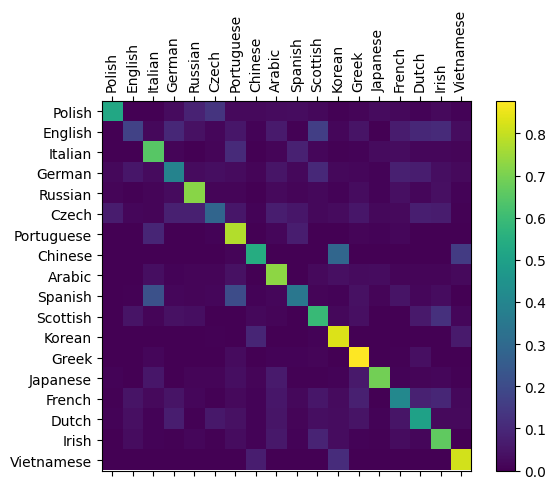

In [43]:
import matplotlib.pyplot as plt  # For plotting the confusion matrix
import matplotlib.ticker as ticker  # For controlling tick marks on the plot

# Initialize a confusion matrix of size [n_categories, n_categories]
# It will keep track of how often each actual category (language) is predicted as each possible category.
confusion = torch.zeros(n_categories, n_categories)

n_confusion = 10000  # Number of examples to evaluate and populate the confusion matrix

# Evaluate a set of random examples to fill the confusion matrix
for i in range(n_confusion):
    # Get a random training example (a name and its actual category)
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Get the model's output for the name
    output = evaluate(line_tensor)

    # Convert the output into the predicted category and its index
    guess, guess_i = categoryFromOutput(output)

    # Get the index of the actual category (true label)
    category_i = all_categories.index(category)

    # Increment the confusion matrix at the position [actual category][predicted category]
    confusion[category_i][guess_i] += 1

# Normalize the confusion matrix by dividing each row by the sum of that row
# This ensures each row represents proportions, making the matrix easier to interpret
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Plotting the confusion matrix
fig = plt.figure()  # Create a new figure for the plot
ax = fig.add_subplot(111)  # Add a subplot (a single plot in this case)

# Plot the confusion matrix using a color map (matshow)
cax = ax.matshow(confusion.numpy())  # Convert the confusion matrix to a NumPy array for plotting
fig.colorbar(cax)  # Add a color bar to indicate the scale of the values

# Set up the axis labels (category names) for both axes
# The x-axis will represent the predicted categories and the y-axis will represent the actual categories
ax.set_xticklabels([''] + all_categories, rotation=90)  # Rotate x-axis labels for readability
ax.set_yticklabels([''] + all_categories)

# Ensure that tick labels are placed at every tick (i.e., for every category)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set major ticks on the x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set major ticks on the y-axis

# Display the plot
plt.show()



**Explanation**:
- **Confusion Matrix**: The matrix keeps track of how often the model predicts each category correctly (diagonal entries) or incorrectly (off-diagonal entries).
- **Normalization**: Dividing by the row sum ensures that each row represents the distribution of predictions for that language, making it easier to see where the model is making mistakes.

---



#### **3.4. Plotting the Training Loss and Validation Loss**

Plotting the loss during training helps monitor how well the model is learning. A decreasing loss generally indicates that the model is improving.

**Code for Plotting the Training Loss**:


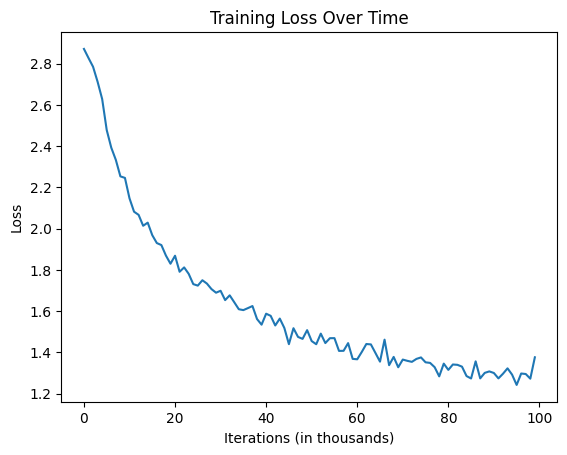

In [44]:
# Create a new figure for plotting the loss
plt.figure()

# Plot the list of losses (collected during training)
# all_losses contains the average loss recorded at regular intervals (e.g., every 1000 iterations)
plt.plot(all_losses)

# Label the x-axis as 'Iterations (in thousands)'
# This indicates that the x-axis represents the number of training iterations
plt.xlabel('Iterations (in thousands)')

# Label the y-axis as 'Loss'
# The y-axis shows the loss values, which measure how well the model is performing (lower is better)
plt.ylabel('Loss')

# Add a title to the plot
plt.title('Training Loss Over Time')

# Display the plot
plt.show()



**Explanation**:
- **all_losses**: This list stores the average loss for every 1000 iterations.
- **Plot**: The plot shows how the loss decreases over time, indicating whether the model is learning effectively.


1. Modify the Training Loop to Track Validation Loss:


In [45]:
# Initialize lists to track both training and validation loss
all_train_losses = []  # Store the training loss
all_val_losses = []    # Store the validation loss

# Example validation data (you need to define your own validation set)
# Let's assume `validation_examples` contains the names and their corresponding categories
validation_examples = [randomTrainingExample() for _ in range(100)]  # Create some dummy validation data

for iter in range(1, n_iters + 1):
    # Get a random training example (a name and its category)
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Train the model on this example and get the output and loss
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Calculate validation loss at every 'plot_every' interval
    if iter % plot_every == 0:
        # Store average training loss
        all_train_losses.append(current_loss / plot_every)
        current_loss = 0

        # Compute the validation loss
        val_loss = 0
        for val_category, val_line, val_category_tensor, val_line_tensor in validation_examples:
            val_output = evaluate(val_line_tensor)
            val_loss += criterion(val_output, val_category_tensor).item()

        # Store average validation loss
        avg_val_loss = val_loss / len(validation_examples)
        all_val_losses.append(avg_val_loss)

        print(f"Iteration {iter}: Training loss: {all_train_losses[-1]:.4f}, Validation loss: {avg_val_loss:.4f}")


Iteration 1000: Training loss: 1.2084, Validation loss: 1.2656
Iteration 2000: Training loss: 1.3168, Validation loss: 1.2801
Iteration 3000: Training loss: 1.3040, Validation loss: 1.2847
Iteration 4000: Training loss: 1.2714, Validation loss: 1.2271
Iteration 5000: Training loss: 1.2200, Validation loss: 1.2140
Iteration 6000: Training loss: 1.2729, Validation loss: 1.1866
Iteration 7000: Training loss: 1.2858, Validation loss: 1.2431
Iteration 8000: Training loss: 1.2421, Validation loss: 1.3422
Iteration 9000: Training loss: 1.2272, Validation loss: 1.2400
Iteration 10000: Training loss: 1.3140, Validation loss: 1.2490
Iteration 11000: Training loss: 1.2570, Validation loss: 1.3431
Iteration 12000: Training loss: 1.1818, Validation loss: 1.3186
Iteration 13000: Training loss: 1.2384, Validation loss: 1.2982
Iteration 14000: Training loss: 1.2940, Validation loss: 1.2325
Iteration 15000: Training loss: 1.2422, Validation loss: 1.3264
Iteration 16000: Training loss: 1.2264, Validatio

2. Plot Both Training and Validation Losses:


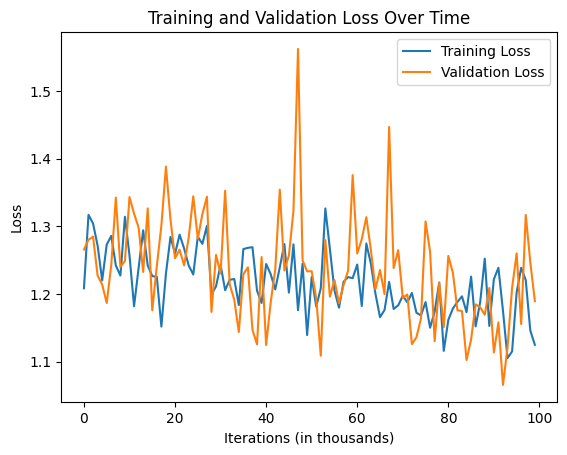

In [46]:
# Plot both training and validation loss on the same graph
plt.figure()

# Plot the training loss
plt.plot(all_train_losses, label='Training Loss')

# Plot the validation loss
plt.plot(all_val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')

# Add a legend to distinguish between training and validation loss
plt.legend()

# Display the plot
plt.show()


##### Key Observations:

1. **Training Loss and Validation Loss Patterns**:
   - The **blue line** represents the **training loss**, and the **orange line** represents the **validation loss**.
   - Both the training and validation losses fluctuate quite a bit but generally follow a downward trend over time, which is a good indication that the model is learning.

2. **Overlapping Periods**:
   - In many sections of the graph (like around 10k, 20k, 30k, etc.), both the training and validation losses are relatively close to each other. This indicates that the model is not overfitting significantly during these periods, as the training and validation performance are aligned.

3. **Spikes in Validation Loss**:
   - There are significant spikes in **validation loss**, especially around 40k and 50k iterations. This might indicate that the model overfits at certain points during training or that the validation set has a few difficult examples that the model struggles with.
   - However, these spikes eventually settle back down, which could mean that the learning process is correcting the model as it progresses.

4. **Validation Loss Higher than Training Loss**:
   - For much of the plot, the **validation loss** is **higher than the training loss**. This is expected in most models because the validation set consists of unseen data, and the model typically performs better on the training data due to exposure and learning from it.
   - If the validation loss becomes significantly higher than the training loss and stays that way, it could indicate **overfitting**. In this case, while there are spikes, they don't persist for long, which suggests the model may not be heavily overfitting.

5. **General Trend**:
   - The general trend of both the training and validation losses is **decreasing** over time, which is a positive sign that the model is learning and improving its performance. While there is noise and fluctuation in the loss, especially in the validation loss, the overall movement is downward.

##### Possible Actions to Improve:
- **Smoothing the Learning Curve**: If the model’s loss fluctuates too much, consider adjusting the learning rate or using a learning rate scheduler. A smaller learning rate might help reduce the spikes.
- **Overfitting Check**: The spikes in validation loss suggest that the model may overfit at certain points. You could:
  - Use **early stopping** to prevent overfitting if validation loss consistently increases.
  - Apply **regularization techniques** (like L2 regularization or dropout) to make the model more robust.
  - Increase the size of the **validation set** to ensure it represents more diverse examples.



### **3.5. Running the Model on User Input**

Finally, after training the model, you can run it on custom names to see how well it performs. This allows you to input any name and check which language the model predicts.

**Code for User Input Prediction**:


In [47]:
def predict(input_name, n_predictions=3):
    # Print the name being predicted
    print(f'\n> {input_name}')

    # Disable gradient calculation since we are only doing inference (evaluation) and not updating any weights
    with torch.no_grad():
        # Convert the input name into a tensor of one-hot encoded letters
        output = evaluate(nameToTensor(input_name))

        # Get the top N predictions (log-probabilities and indices) from the output
        # topk(n_predictions, 1, True) gets the top `n_predictions` categories
        # topv contains the top values (log-probabilities), topi contains the indices of the categories
        topv, topi = output.topk(n_predictions, 1, True)

        # List to store the predicted categories and their corresponding probabilities
        predictions = []

        # Loop through the top N predictions
        for i in range(n_predictions):
            # Extract the value (log-probability) for the i-th prediction
            value = topv[0][i].item()

            # Extract the index of the predicted category
            category_index = topi[0][i].item()

            # Print the predicted category and its log-probability
            print(f'({value:.2f}) {all_categories[category_index]}')

            # Append the predicted category and its log-probability to the list
            predictions.append((value, all_categories[category_index]))

    # Return the list of predictions (each with its log-probability and category name)
    return predictions

# Example usage of the predict function
predict('Satoshi')  # Predict the language/category for the name 'Satoshi'



> Satoshi
(-0.34) Arabic
(-1.65) Japanese
(-3.24) Italian


[(-0.3434559106826782, 'Arabic'),
 (-1.6498302221298218, 'Japanese'),
 (-3.2424826622009277, 'Italian')]


**Explanation**:

  - Top Predicted Categories:

    - The model has returned the top 3 predicted languages (or categories) for the name "Satoshi" along with their associated log-probabilities.
    - The results are:

      -  Arabic: Log-probability = -0.34
      -  Japanese: Log-probability = -1.65
      -  Italian: Log-probability = -3.24
    - Interpretation of Log-Probabilities:

      -  Log-probabilities are negative because they represent the logarithm of probabilities, which are between 0 and 1.
      -  A log-probability closer to 0 (i.e., less negative) indicates a higher probability. For example:
        -  Arabic has the highest log-probability of -0.34, meaning the model is most confident that "Satoshi" belongs to the Arabic category.
        -  Japanese has a lower log-probability of -1.65, meaning the model is less confident but still considers it a possible category.
        -  Italian has the lowest confidence, with a log-probability of -3.24.
  -  Confidence in Prediction:

    The model’s top prediction is Arabic with a log-probability of -0.34, which suggests a fairly confident prediction compared to the other two categories.
    However, this is surprising since "Satoshi" is a well-known Japanese name. The fact that Japanese is ranked second with a significantly lower log-probability (-1.65) indicates that the model is not particularly confident in the correct prediction.
---

---
---
---
---
---
---
---
---
---
---